# Notebook 3: Photo-Z regression calculator

This notebook calculates a regression fit for photometric redshifts of galaxies. It uses the following steps:

- Queries a training set of galaxies for which redshifts are available (redshift is a rough measure of the distance to a galaxy).
- Derives a k-nearest-neighbour regressor that determines a redshift estimate from 5 "broad-band" magnitudes
- Tests the derived regressor against a test dataset by plotting actual redshifts of galaxies in the test set against redshifts predicted by the regressor.

Author: Jake VanderPlas (vanderplas@astro.washington.edu)

License: BSD

The figure is an example from astroML: see http://astroml.github.com

Modified to work with SDSS data by Dmitry Medvedev (dmedv@jhu.edu)

In [1]:
import SciServer.CasJobs as CasJobs   # work with CasJobs
from io import StringIO   # work with strings
import numpy as np   # standard Python math package
import pandas   # "pandas" package for data processing
from matplotlib import pyplot as plt   # plotting
from sklearn.neighbors import KNeighborsRegressor   # find regressor
from astroML.plotting import scatter_contour   # make scatterplot

In [2]:
# some special settings
# ensure columns get written completely in notebook
pandas.set_option('display.max_colwidth', -1)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
NOBJECTS = 20000
#GAL_COLORS_DTYPE = [('u', float),
#                    ('g', float),
#                    ('r', float),
#                    ('i', float),
#                    ('z', float),
#                    ('redshift', float),
#                    ('redshift_err', float)]

Now we do this

In [4]:
# get data from CasJobs: first, set up the query we want to run
query_text = ('\n'.join(
    ("SELECT TOP %i" % NOBJECTS,
    "   p.u, p.g, p.r, p.i, p.z, s.z as redshift, s.zerr as redshift_err",
    "FROM PhotoObj AS p",
    "   JOIN SpecObj AS s ON s.bestobjid = p.objid",
    "WHERE ",
    "   p.u BETWEEN 0 AND 19.6",
    "   AND p.g BETWEEN 0 AND 20",
    "   AND (s.class = 'GALAXY' OR s.class = 'QSO')")))

# run the query and store the results as a pandas DataFrame
data_df = CasJobs.executeQuery(query_text,"DR13")

print('Done')

Done


In [5]:
# show some of the data
data_df.head(10)

,u,g,r,i,z,redshift,redshift_err
0,19.05989,17.49459,16.59285,16.09412,15.70741,0.044277,0.000011
1,19.45567,18.33084,17.67185,17.30189,17.13650,0.041644,0.000018
2,18.27065,18.08745,18.08966,18.22180,18.37045,0.396530,0.056599
3,18.94490,17.45382,16.71061,16.26543,15.94860,0.073319,0.000010
4,18.84868,16.86433,15.90334,15.42890,15.08823,0.057814,0.000016
5,19.03113,17.93515,17.49739,17.15799,16.99095,0.081877,0.000008
6,19.34175,18.33376,17.95975,17.67543,17.54168,0.082040,0.000006
7,19.20547,18.21573,17.73127,17.42313,17.32267,0.082187,0.000006
8,16.62952,14.88339,14.55241,14.57238,15.26632,0.006618,0.000023
9,19.16411,17.27371,16.31466,15.78471,15.44008,0.082839,0.000012


In [6]:
n_neighbors = 1

N = len(data_df.index)

# Divide the data into equal-sized training and test datasets (by masking using a random numpy array)
msk = np.random.rand(N) < 0.5  # The 0.5 sets the size of the training set
train_df = data_df[msk]
test_df = data_df[~msk]

#print('Length of training data: {0}'.format(len(train_df.index)))
#print('Length of test data: {0}'.format(len(test_df.index)))
#print('\n')

# put colors in a matrix - first for the training set, then for the test set
Ntrain = len(train_df.index)
Xtrain = np.zeros((Ntrain,4))
Xtrain[:,0] = train_df['u'] - train_df['g']
Xtrain[:, 1] = train_df['g'] - train_df['r']
Xtrain[:, 2] = train_df['r'] - train_df['i']
Xtrain[:, 3] = train_df['i'] - train_df['z']
ztrain = train_df['redshift']

#print('First 3 rows of Xtrain:')
#print(Xtrain[0:2,:])
#print('\n')

# put colors in a matrix - first for the training set, then for the test set
Ntest = len(test_df.index)
Xtest = np.zeros((Ntest,4))
Xtest[:,0] = test_df['u'] - test_df['g']
Xtest[:, 1] = test_df['g'] - test_df['r']
Xtest[:, 2] = test_df['r'] - test_df['i']
Xtest[:, 3] = test_df['i'] - test_df['z']
ztest = test_df['redshift']

#print('First 3 rows of Xtest:')
#print(Xtrain[0:2,:])

knn = KNeighborsRegressor(n_neighbors, weights='uniform')
zpred = knn.fit(Xtrain, ztrain).predict(Xtest)

rms = np.sqrt(np.mean((ztest - zpred) ** 2))
print("RMS error = %.2g" % rms)

RMS error = 0.37


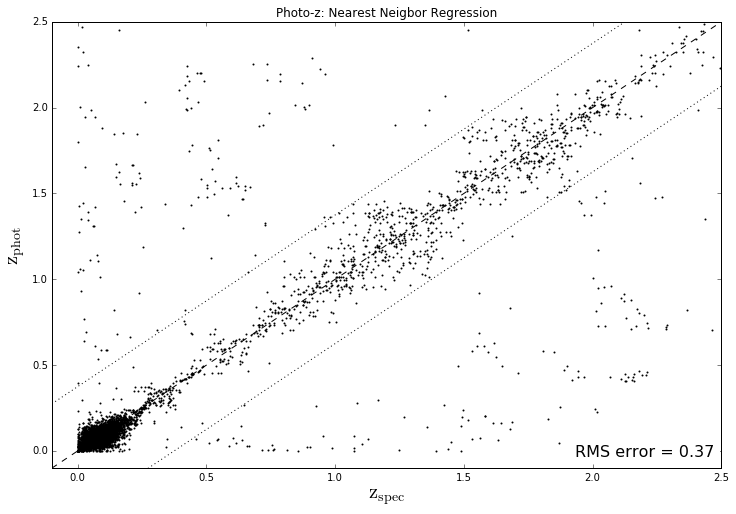

In [7]:
axis_lim = np.array([-0.1, 2.5])

plt.figure(figsize=(12, 8))
ax = plt.axes()
plt.scatter(ztest, zpred, c='k', lw=0, s=4)
plt.plot(axis_lim, axis_lim, '--k')
plt.plot(axis_lim, axis_lim + rms, ':k')
plt.plot(axis_lim, axis_lim - rms, ':k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)

plt.text(0.99, 0.02, "RMS error = %.2g" % rms,
         ha='right', va='bottom', transform=ax.transAxes,
         bbox=dict(ec='w', fc='w'), fontsize=16)

plt.title('Photo-z: Nearest Neigbor Regression')
plt.xlabel(r'$\mathrm{z_{spec}}$', fontsize=20)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=20)
plt.show()